In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [22]:
mcftr = pd.read_csv('data/MCFTR.csv', encoding='windows-1251', sep=';')
gold = pd.read_excel('data/gold.xlsx')
imoex = pd.read_csv('data/imoex.csv',encoding='windows-1251', sep=';')
imoex = imoex[['TRADEDATE', 'CLOSE']]
mcftr = mcftr[['TRADEDATE', 'CLOSE']]
snp = pd.read_csv('data/sp500.csv', sep=',')
snptr = pd.read_csv('data/snptr.csv', sep=',')
snptr['Open'] = snptr['Open'].apply(lambda x: float(x.replace(',', '')))

In [23]:
mcftr['date'] = pd.to_datetime(mcftr['TRADEDATE'], format='%Y-%m-%d')
gold['date'] = pd.to_datetime(gold['Дата'], format='%Y-%m-%d')
imoex['date'] = pd.to_datetime(imoex['TRADEDATE'], format='%d.%m.%Y')
snp['date'] = pd.to_datetime(snp['Date'])
snptr['date'] = pd.to_datetime(snptr['Date'])

# filter dates to start from 2015-01-10
mcftr = mcftr[mcftr['date'] >= '2015-01-10']
gold = gold[gold['date'] >= '2015-01-10']
imoex = imoex[imoex['date'] >= '2015-01-10']
snp = snp[snp['date'] >= '2015-01-10']
snptr = snptr[snptr['date'] >= '2015-01-10']

mcftr['price'] = pd.to_numeric(mcftr['CLOSE'])
gold['price'] = pd.to_numeric(gold['Значение'])
imoex['price'] = pd.to_numeric(imoex['CLOSE'])
snp['price'] = pd.to_numeric(snp['Close/Last'])
snptr['price'] = pd.to_numeric(snptr['Open'])

mcftr = mcftr[['date', 'price']]
gold = gold[['date', 'price']]
imoex = imoex[['date', 'price']]
snp = snp[['date', 'price']]
snptr = snptr[['date', 'price']]

mcftr['price_in_gold'] = mcftr['price'] / gold['price']
imoex['price_in_gold'] = imoex['price'] / gold['price']
snp['price_in_gold'] = snp['price'] / gold['price']
snptr['price_in_gold'] = snptr['price'] / gold['price']

In [24]:
# Function to fill missing dates with most recent known price
def fill_missing_dates(df):
    df = df.sort_values('date')
    df = df.set_index('date')
    idx = pd.date_range(df.index.min(), df.index.max())
    df = df.reindex(idx)
    df['price'] = df['price'].ffill()
    return df.reset_index().rename(columns={'index': 'date'})

# Apply the function to each dataframe
mcftr = fill_missing_dates(mcftr)
gold = fill_missing_dates(gold)
imoex = fill_missing_dates(imoex)
snp = fill_missing_dates(snp)
snptr = fill_missing_dates(snptr)

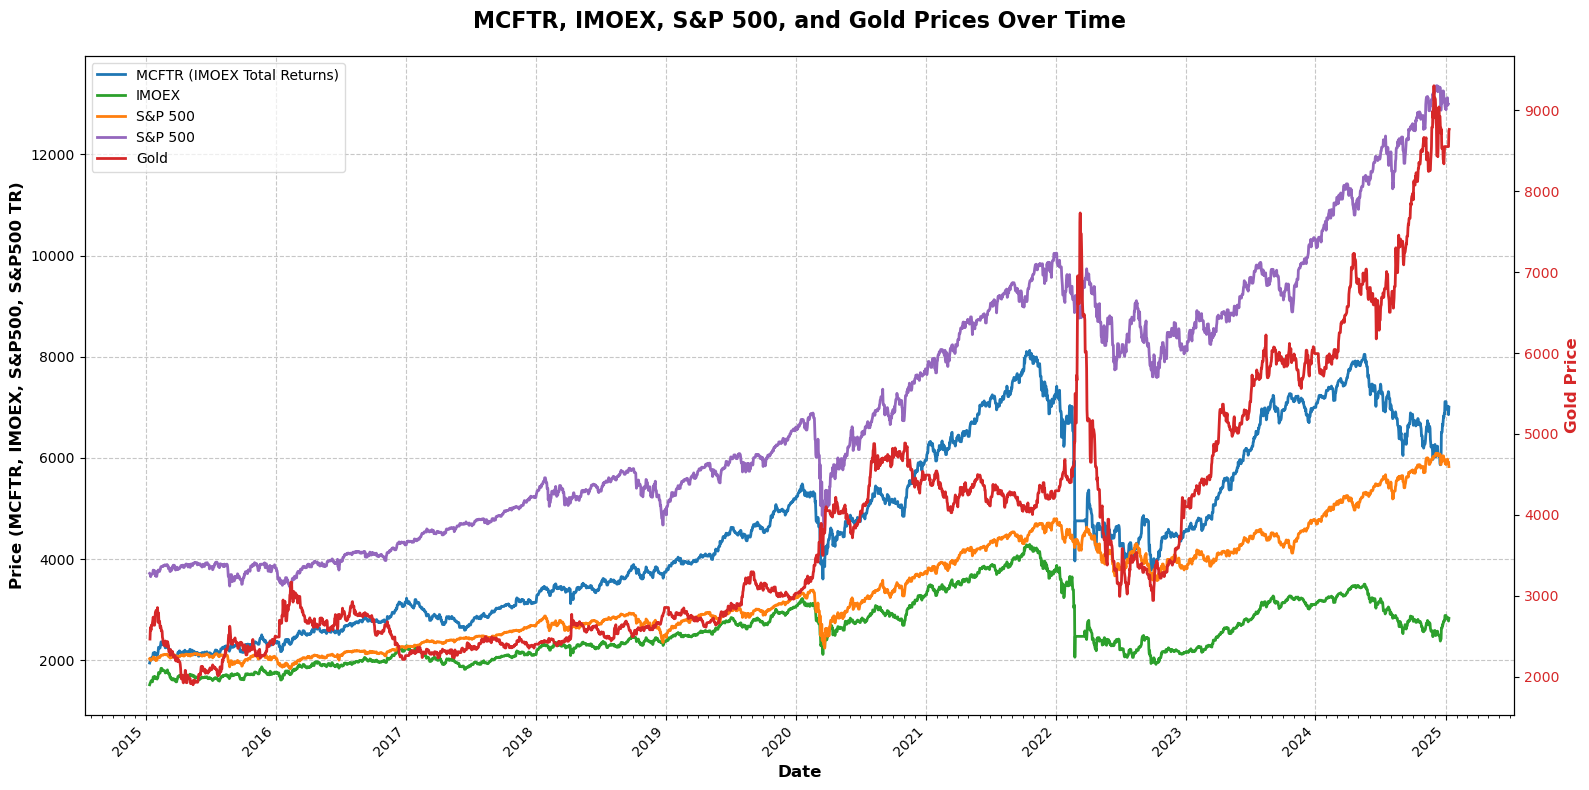

In [25]:
# Matplotlib graph
fig, ax1 = plt.subplots(figsize=(16, 8))


# Plot MCFTR, IMOEX, and S&P 500 on the left y-axis
ax1.plot(mcftr['date'], mcftr['price'], label='MCFTR (IMOEX Total Returns)', color='#1f77b4', linewidth=2)
ax1.plot(imoex['date'], imoex['price'], label='IMOEX', color='#2ca02c', linewidth=2)
ax1.plot(snp['date'], snp['price'], label='S&P 500', color='#ff7f0e', linewidth=2)
ax1.plot(snptr['date'], snptr['price'], label='S&P 500', color='#9467bd', linewidth=2)

ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Price (MCFTR, IMOEX, S&P500, S&P500 TR)', color='black', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black', labelsize=10)

# Plot Gold price on the right y-axis
ax2 = ax1.twinx()
ax2.plot(gold['date'], gold['price'], color='#d62728', label='Gold', linewidth=2)
ax2.set_ylabel('Gold Price', color='#d62728', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#d62728', labelsize=10)

# Improve x-axis date formatting
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add legend with improved positioning and style
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10, frameon=True, framealpha=0.7)

# Set title with improved font
plt.title('MCFTR, IMOEX, S&P 500, and Gold Prices Over Time', fontsize=16, fontweight='bold', pad=20)

# Add grid for better readability
ax1.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [26]:
merged_df = pd.merge(mcftr, gold, on='date', suffixes=('_mcftr', '_gold'))
merged_df = pd.merge(merged_df, imoex, on='date', suffixes=('', '_imoex'))
merged_df = pd.merge(merged_df, snp, on='date', suffixes=('', '_snp'))
merged_df = pd.merge(merged_df, snptr, on='date', suffixes=('', '_snptr'))
merged_df.rename(columns={'price': 'price_imoex'}, inplace=True)

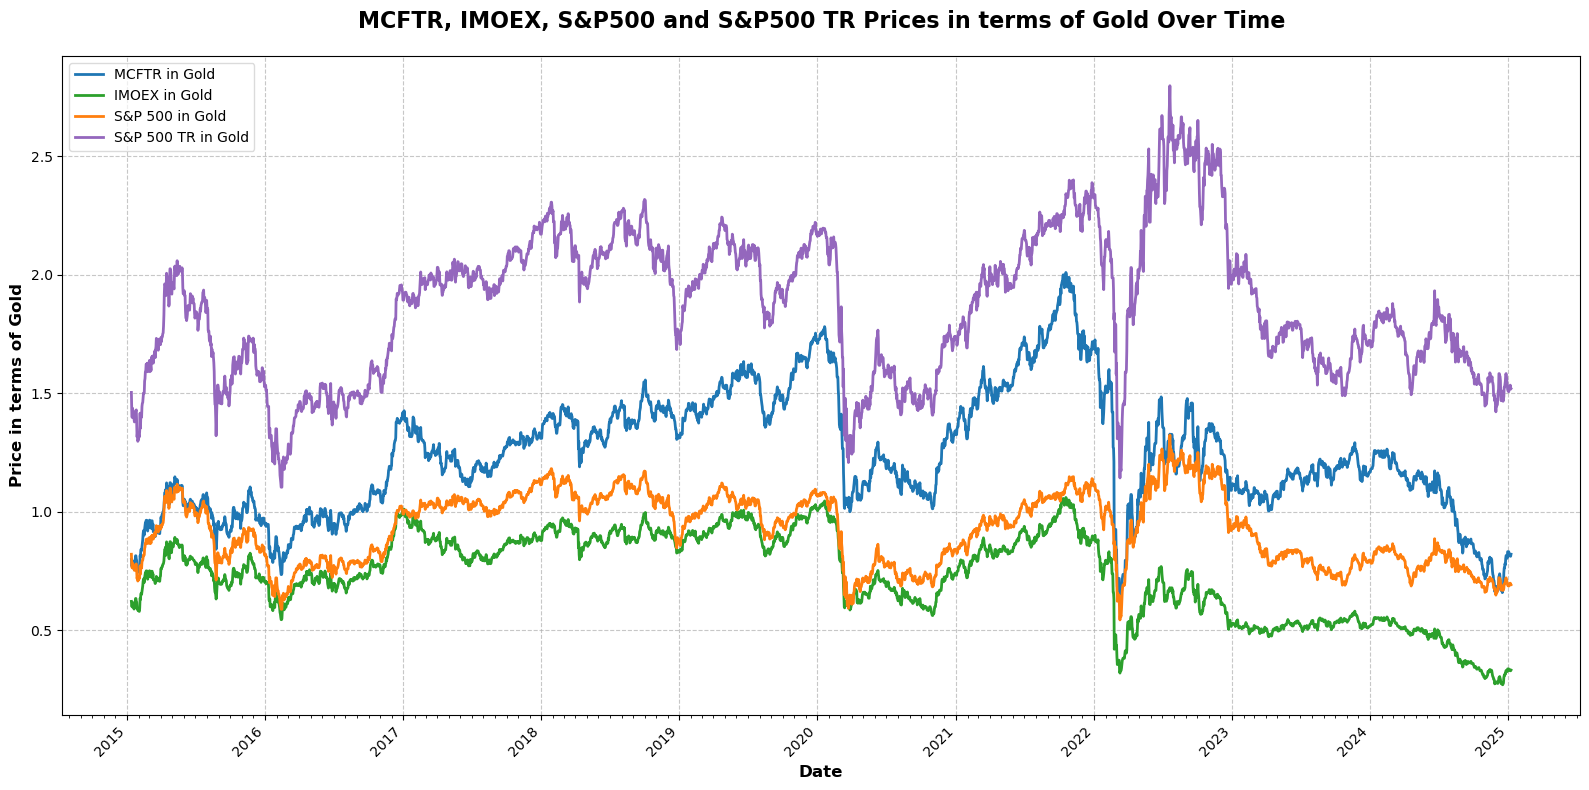

In [27]:

# Calculate prices in terms of gold
merged_df['mcftr_gold'] = merged_df['price_mcftr'] / merged_df['price_gold']
merged_df['imoex_gold'] = merged_df['price_imoex'] / merged_df['price_gold']
merged_df['snp_gold'] = merged_df['price_snp'] / merged_df['price_gold']
merged_df['snptr_gold'] = merged_df['price_snptr'] / merged_df['price_gold']

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot MCFTR, IMOEX, and S&P 500 in terms of gold
ax.plot(merged_df['date'], merged_df['mcftr_gold'], label='MCFTR in Gold', color='#1f77b4', linewidth=2)
ax.plot(merged_df['date'], merged_df['imoex_gold'], label='IMOEX in Gold', color='#2ca02c', linewidth=2)
ax.plot(merged_df['date'], merged_df['snp_gold'], label='S&P 500 in Gold', color='#ff7f0e', linewidth=2)
ax.plot(merged_df['date'], merged_df['snptr_gold'], label='S&P 500 TR in Gold', color='#9467bd', linewidth=2)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Price in terms of Gold', color='black', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelcolor='black', labelsize=10)

# Improve x-axis date formatting
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add legend with improved positioning and style
ax.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.7)

# Set title with improved font
plt.title('MCFTR, IMOEX, S&P500 and S&P500 TR Prices in terms of Gold Over Time', fontsize=16, fontweight='bold', pad=20)

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

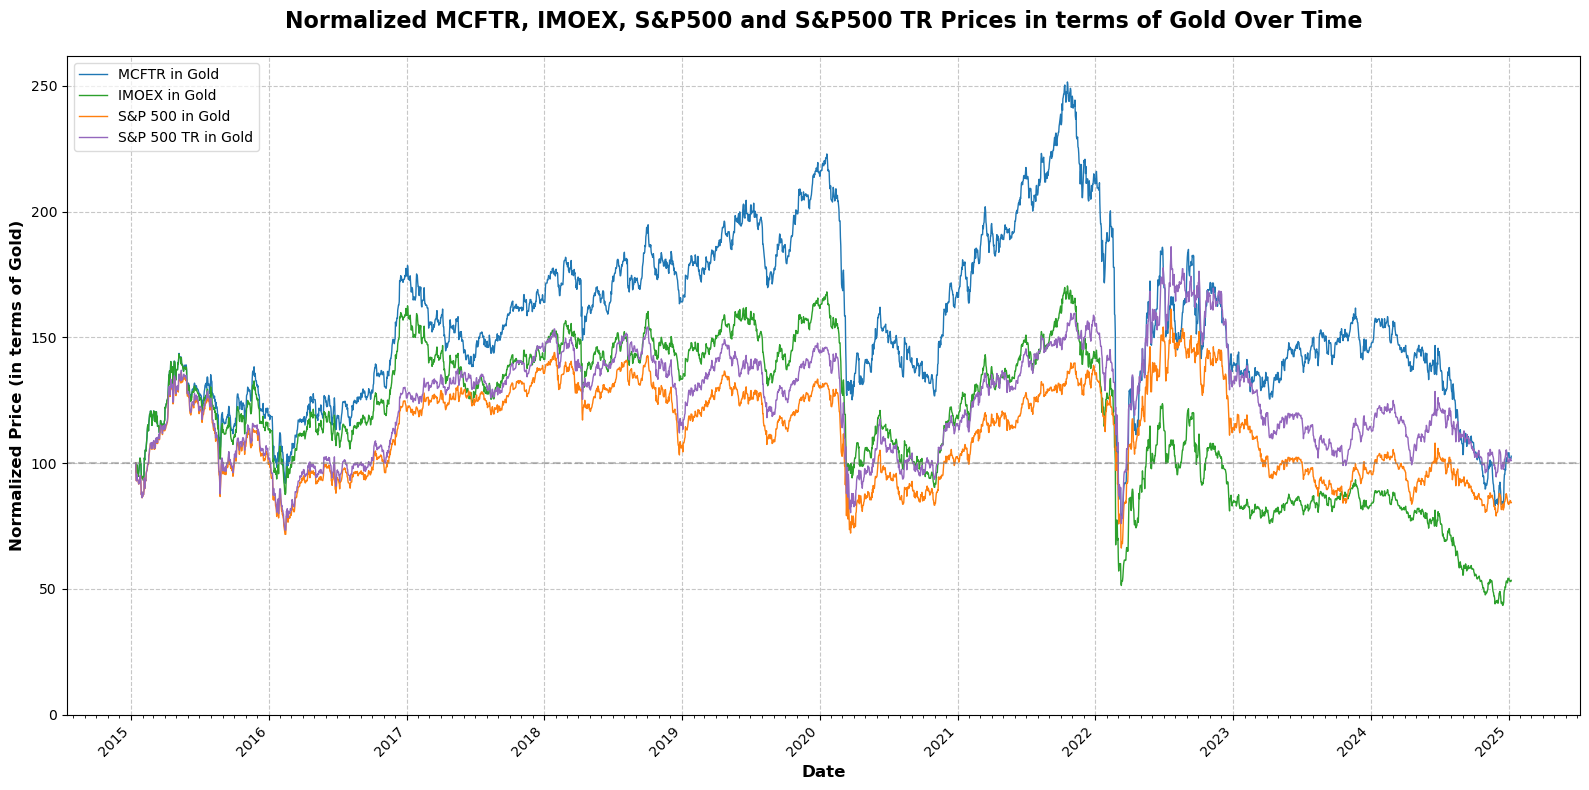

In [28]:
# Normalize prices in terms of gold
merged_df['mcftr_gold_normalized'] = merged_df['mcftr_gold'] / merged_df['mcftr_gold'].iloc[0] * 100
merged_df['imoex_gold_normalized'] = merged_df['imoex_gold'] / merged_df['imoex_gold'].iloc[0] * 100
merged_df['snp_gold_normalized'] = merged_df['snp_gold'] / merged_df['snp_gold'].iloc[0] * 100
merged_df['snptr_gold_normalized'] = merged_df['snptr_gold'] / merged_df['snptr_gold'].iloc[0] * 100

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot normalized MCFTR, IMOEX, and S&P 500 in terms of gold
ax.plot(merged_df['date'], merged_df['mcftr_gold_normalized'], label='MCFTR in Gold', color='#1f77b4', linewidth=1)
ax.plot(merged_df['date'], merged_df['imoex_gold_normalized'], label='IMOEX in Gold', color='#2ca02c', linewidth=1)
ax.plot(merged_df['date'], merged_df['snp_gold_normalized'], label='S&P 500 in Gold', color='#ff7f0e', linewidth=1)
ax.plot(merged_df['date'], merged_df['snptr_gold_normalized'], label='S&P 500 TR in Gold', color='#9467bd', linewidth=1)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Normalized Price (in terms of Gold)', color='black', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelcolor='black', labelsize=10)

# Improve x-axis date formatting
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add legend with improved positioning and style
ax.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.7)

# Set title with improved font
plt.title('Normalized MCFTR, IMOEX, S&P500 and S&P500 TR Prices in terms of Gold Over Time', fontsize=16, fontweight='bold', pad=20)

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Set y-axis to start from 0
ax.set_ylim(bottom=0)

# Add a horizontal line at y=100 to show the starting point
ax.axhline(y=100, color='gray', linestyle='--', alpha=0.5)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

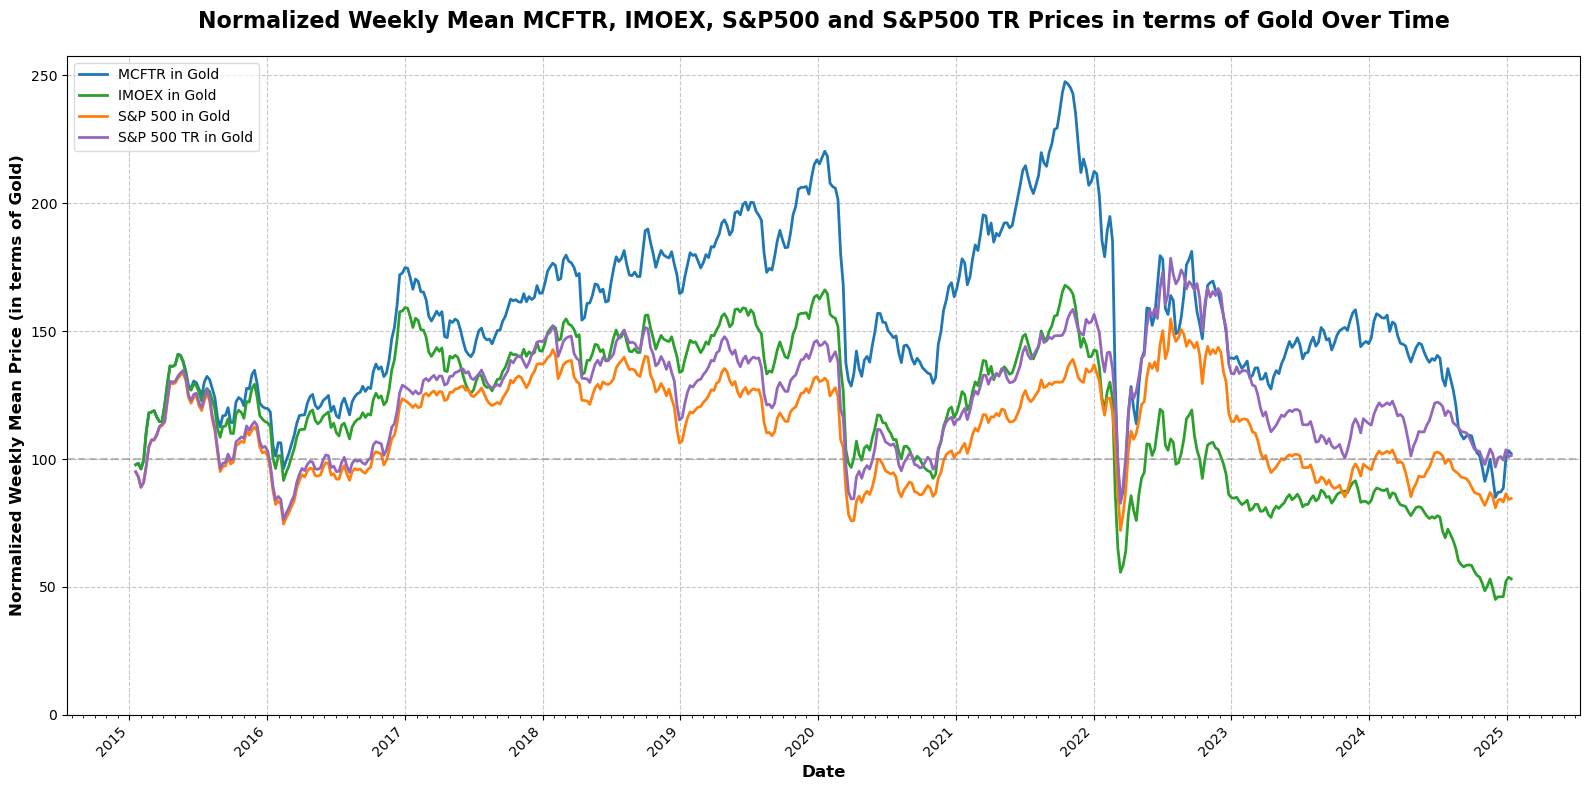

In [29]:
# Normalize prices in terms of gold
merged_df['mcftr_gold_normalized'] = merged_df['mcftr_gold'] / merged_df['mcftr_gold'].iloc[0] * 100
merged_df['imoex_gold_normalized'] = merged_df['imoex_gold'] / merged_df['imoex_gold'].iloc[0] * 100
merged_df['snp_gold_normalized'] = merged_df['snp_gold'] / merged_df['snp_gold'].iloc[0] * 100
merged_df['snptr_gold_normalized'] = merged_df['snptr_gold'] / merged_df['snptr_gold'].iloc[0] * 100

# Convert date to datetime if it's not already
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Calculate weekly mean prices
weekly_df = merged_df.resample('W', on='date').mean().reset_index()

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot normalized weekly mean MCFTR, IMOEX, and S&P 500 in terms of gold
ax.plot(weekly_df['date'], weekly_df['mcftr_gold_normalized'], label='MCFTR in Gold', color='#1f77b4', linewidth=2)
ax.plot(weekly_df['date'], weekly_df['imoex_gold_normalized'], label='IMOEX in Gold', color='#2ca02c', linewidth=2)
ax.plot(weekly_df['date'], weekly_df['snp_gold_normalized'], label='S&P 500 in Gold', color='#ff7f0e', linewidth=2)
ax.plot(weekly_df['date'], weekly_df['snptr_gold_normalized'], label='S&P 500 TR in Gold', color='#9467bd', linewidth=2)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Normalized Weekly Mean Price (in terms of Gold)', color='black', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelcolor='black', labelsize=10)

# Improve x-axis date formatting
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add legend with improved positioning and style
ax.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.7)

# Set title with improved font
plt.title('Normalized Weekly Mean MCFTR, IMOEX, S&P500 and S&P500 TR Prices in terms of Gold Over Time', fontsize=16, fontweight='bold', pad=20)

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Set y-axis to start from 0
ax.set_ylim(bottom=0)

# Add a horizontal line at y=100 to show the starting point
ax.axhline(y=100, color='gray', linestyle='--', alpha=0.5)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

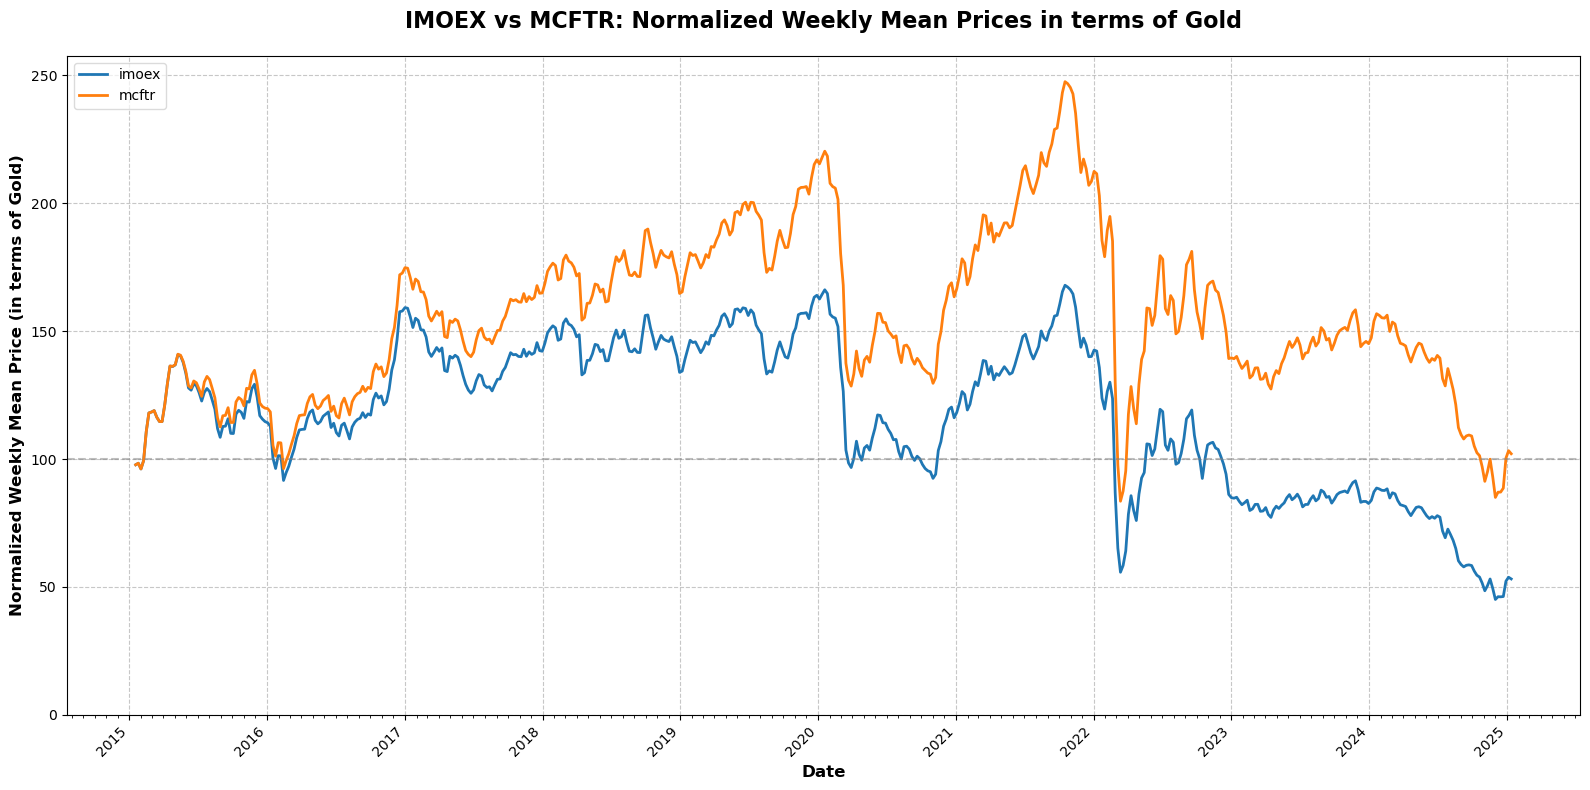

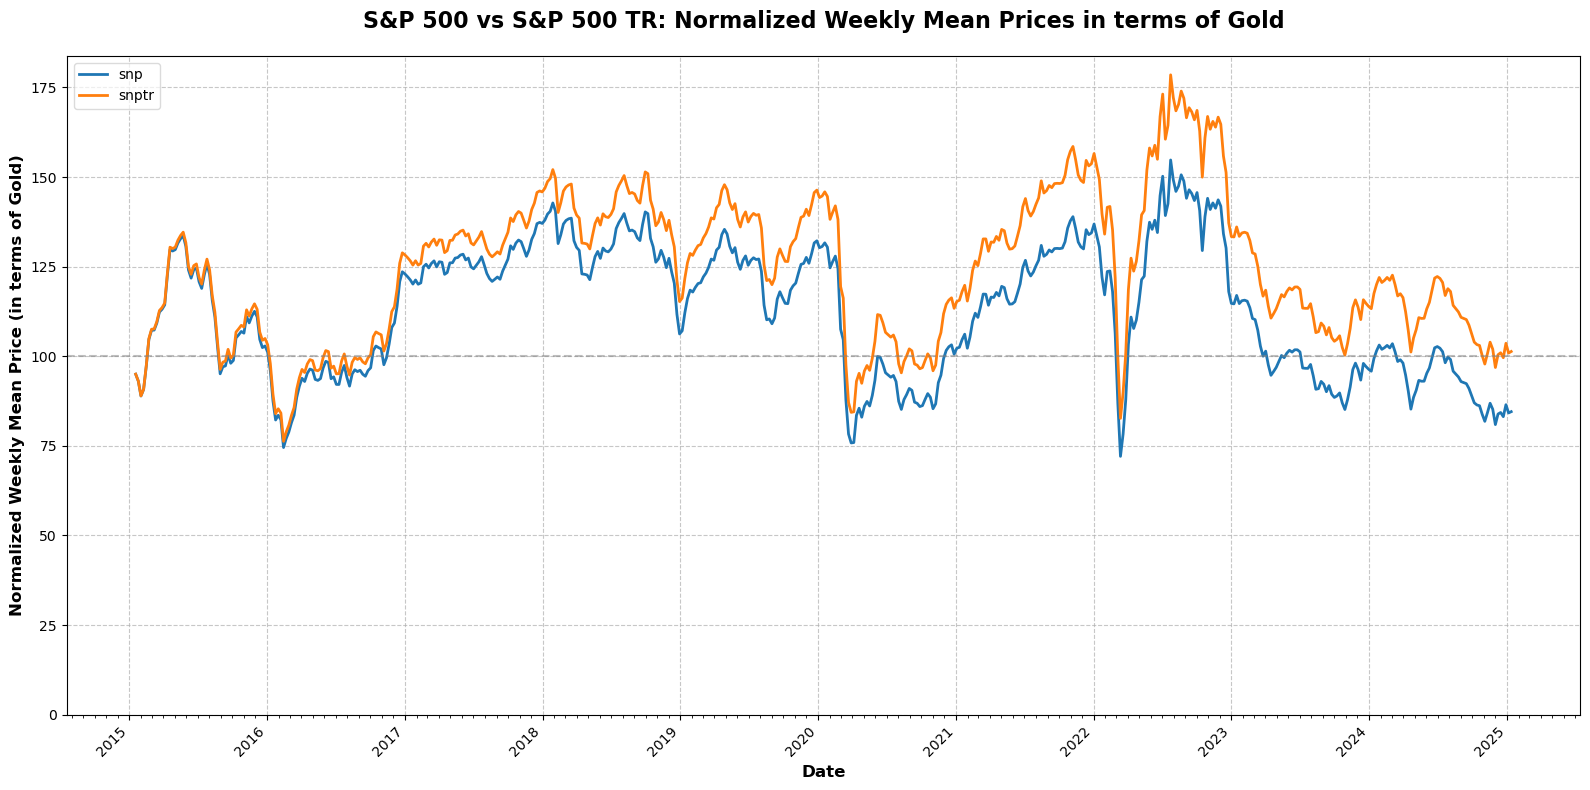

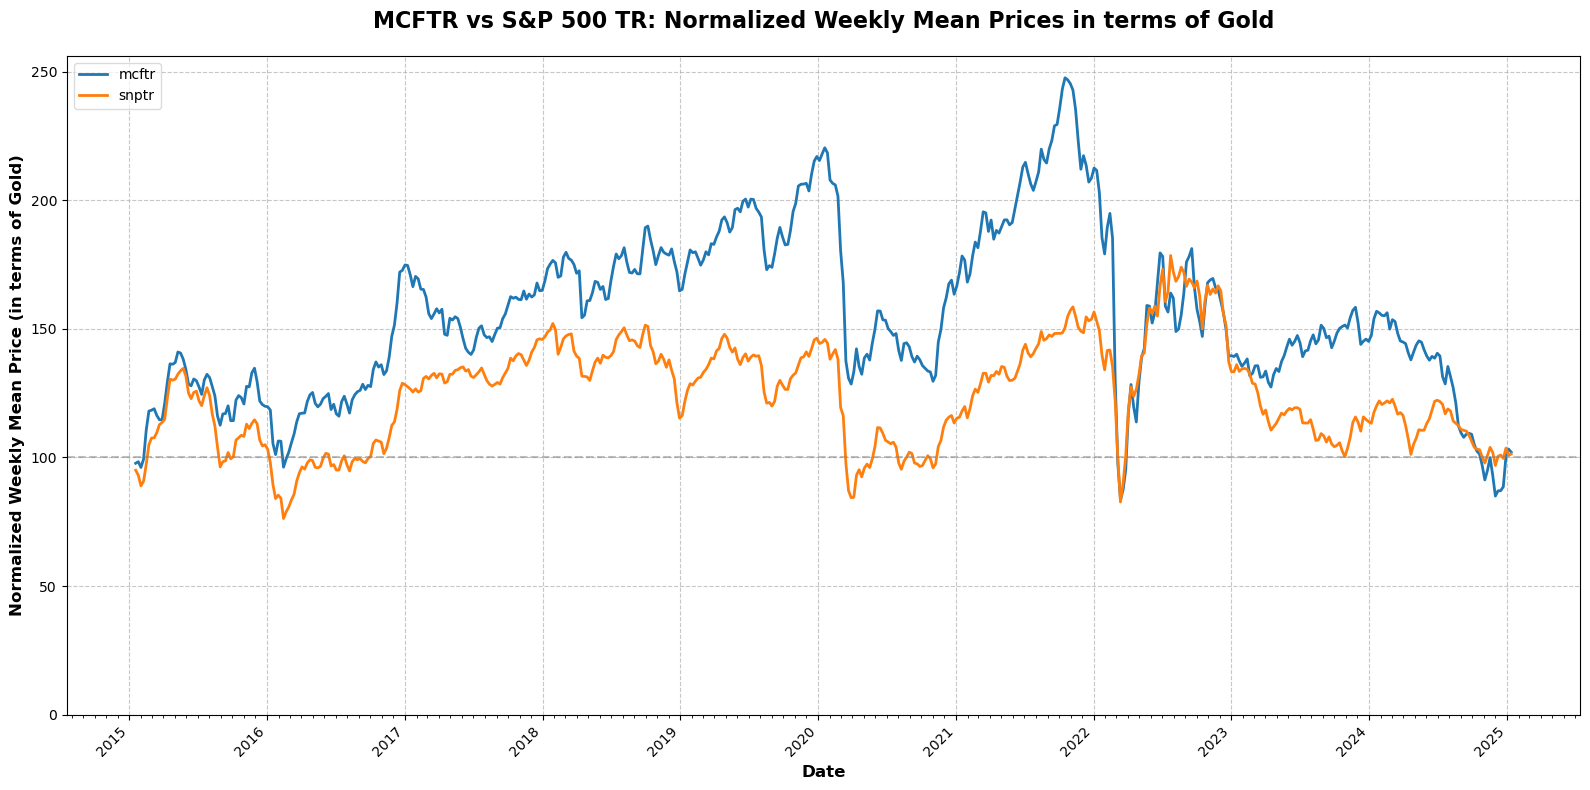

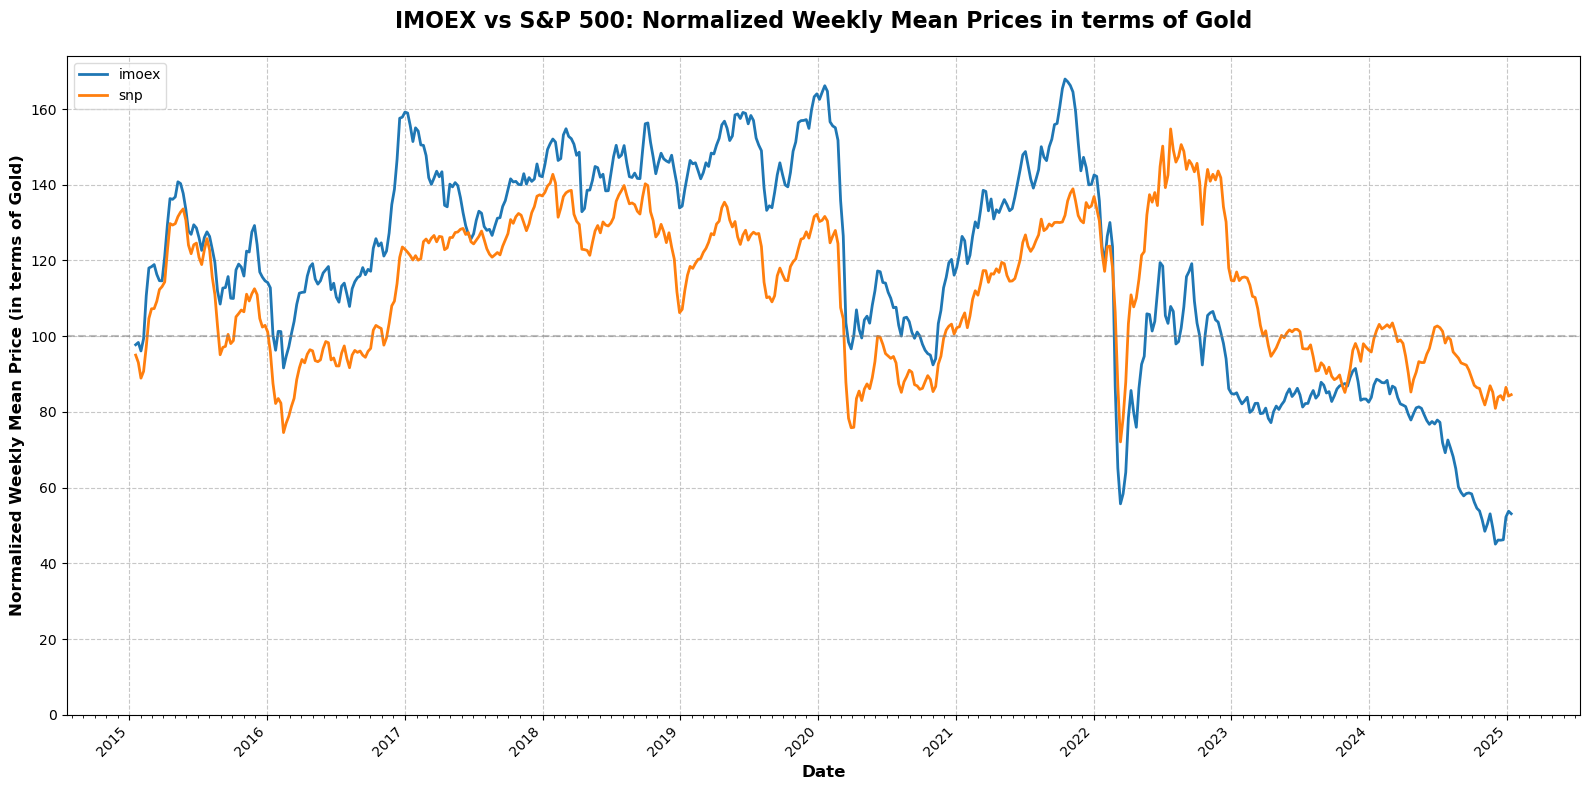

In [30]:
# Function to create a graph for two indices
def create_comparison_graph(df, index1, index2, title):
    fig, ax = plt.subplots(figsize=(16, 8))
    
    ax.plot(df['date'], df[f'{index1}_gold_normalized'], label=index1, linewidth=2)
    ax.plot(df['date'], df[f'{index2}_gold_normalized'], label=index2, linewidth=2)
    
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Normalized Weekly Mean Price (in terms of Gold)', color='black', fontsize=12, fontweight='bold')
    ax.tick_params(axis='y', labelcolor='black', labelsize=10)
    
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    ax.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.7)
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim(bottom=0)
    ax.axhline(y=100, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Create graphs for each pair
create_comparison_graph(weekly_df, 'imoex', 'mcftr', 'IMOEX vs MCFTR: Normalized Weekly Mean Prices in terms of Gold')
create_comparison_graph(weekly_df, 'snp', 'snptr', 'S&P 500 vs S&P 500 TR: Normalized Weekly Mean Prices in terms of Gold')
create_comparison_graph(weekly_df, 'mcftr', 'snptr', 'MCFTR vs S&P 500 TR: Normalized Weekly Mean Prices in terms of Gold')
create_comparison_graph(weekly_df, 'imoex', 'snp', 'IMOEX vs S&P 500: Normalized Weekly Mean Prices in terms of Gold')

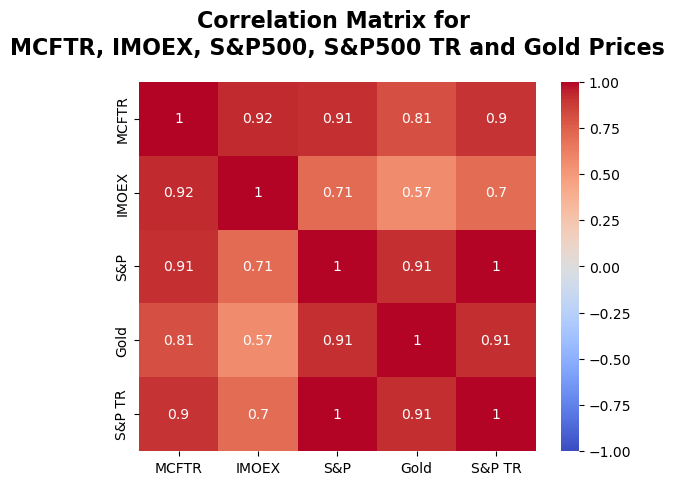

In [31]:
# calculate the correlation between the MCFTR, IMOEX, and S&P 500 and gold prices
correlation_gold_prices = merged_df[['price_mcftr', 'price_imoex', 'price_snp', 'price_gold', 'price_snptr']].corr()
correlation_gold_prices

# label the correlation matrix
correlation_gold_prices.columns = ['MCFTR', 'IMOEX', 'S&P', 'Gold', 'S&P TR' ]
correlation_gold_prices.index = ['MCFTR', 'IMOEX', 'S&P', 'Gold', 'S&P TR' ]

# visualize the correlation matrix
sns.heatmap(correlation_gold_prices, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for \nMCFTR, IMOEX, S&P500, S&P500 TR and Gold Prices', fontsize=16, fontweight='bold', pad=20)
plt.show()